<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Practice_captioning/blob/branch_%EB%B0%B1%EC%9A%B4%EC%B2%A0/custom_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> Image captioning is the task of generating textual descriptions of a given image, requiring  techniques of computer vision and natural language processing.

It is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.  [source](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) 

Here, I have used [COCO Dataset 2017](https://cocodataset.org/#download) which contains **12 different types of categories** and among them it has **80 types of sub-categories**. Each sub categories contain list of images and five captions to each image.

In [1]:
# (코드는 Xception + LSTM + Token(코코데이터셋 전체로 만든 토큰사용))

# 코드는 CTRL+F 로  멈춰 까지 돌리면됩니다.
# a

In [2]:
# !wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip 전체롤드


In [3]:

# from zipfile import ZipFile, BadZipFile
# import os
# def extract_zip_file(extract_path):
#     try:
#         with ZipFile(extract_path+".zip") as zfile:
#             zfile.extractall(extract_path)
#         # remove zipfile
#         zfileTOremove=f"{extract_path}"+".zip"
#         if os.path.isfile(zfileTOremove):
#             os.remove(zfileTOremove)
#         else:
#             print("Error: %s file not found" % zfileTOremove)    
#     except BadZipFile as e:
#         print("Error:", e)
# extract_train_path = "./coco_train2017"
# # extract_val_path = "./coco_val2017"
# # extract_ann_path="./coco_ann2017"
# extract_zip_file(extract_train_path)
# # extract_zip_file(extract_val_path)
# # extract_zip_file(extract_ann_path)

In [4]:

# import os
# total_path = "/content/coco_train2017/train2017" # all cocodataset
# total_train = os.listdir(total_path)



In [5]:
# print(len(total_train))

# print(total_train[-1])

In [6]:
# import pickle 

# with open("my_part.pkl", "rb") as f:
#     load_part = pickle.load(f)

# my_part_1, my_part_2, my_part_3 = load_part["C"]# 3개 리스트


In [7]:
# print(my_part_1)

# # for jpg_path in my_part_1:
# #   if jpg_path in sample_train:


### 드라이브 마운트 & os확인

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [9]:
# # # 뒤에 숫자만 수정 (01~12)

# /content/drive/MyDrive/cocodataset/destination_folder/train_folder01
sample_path = "/content/drive/MyDrive/destination_folder/train_folder01" # 10,000 cocodataset

my_part = sample_path[-14:]






In [10]:
import os

## 전체 파일 확인용

sample_paths =[]
for i in range(12):
  # /content/drive/MyDrive/cocodataset/destination_folder/train_folder01
  sample_path = "/content/drive/MyDrive/destination_folder/train_folder" # 10,000 cocodataset

  # my_part = sample_path[-14:]
  sample_paths.append("{}{:02d}".format(sample_path, i+1))




In [11]:

for i, sample_path in enumerate(sample_paths):
  path_len = len(os.listdir(sample_path))
  print(i+1,":", path_len)
  # if path_len <8000:
    # break

1 : 10000
2 : 10000
3 : 10000
4 : 10000
5 : 10000
6 : 10000
7 : 10000
8 : 10000
9 : 10000
10 : 10008
11 : 10000
12 : 8287


In [12]:
import os

sample_path = "/content/drive/MyDrive/destination_folder/train_folder" # 10,000 cocodataset
sample_train = os.listdir(sample_path+"01")

In [13]:
# 데이터 feature 추출할때.

# sample_train = my_part_1

In [14]:

print(len(sample_train), sample_train[:3])

10000 ['000000012497.jpg', '000000048103.jpg', '000000044251.jpg']


In [15]:
 !pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:

# /content/drive/MyDrive/cocodataset/destination_folder/train_folder01
# /content/drive/MyDrive/coco_ann2017/annotations


# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [17]:
import pandas as pd
i = 0
with open(f'/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption'],sample['image_id']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption','image_id'])
captions['image'] = captions['image'].apply(
    lambda x: f'/content/drive/MyDrive/coco_dataset//train2017/{x}'
)
captions = captions.reset_index(drop=True)
print(captions.head())



                                               image  \
0  /content/drive/MyDrive/coco_dataset//train2017...   
1  /content/drive/MyDrive/coco_dataset//train2017...   
2  /content/drive/MyDrive/coco_dataset//train2017...   
3  /content/drive/MyDrive/coco_dataset//train2017...   
4  /content/drive/MyDrive/coco_dataset//train2017...   

                                             caption  image_id  
0  A bicycle replica with a clock as the front wh...    203564  
1  A room with blue walls and a white sink and door.    322141  
2  A car that seems to be parked illegally behind...     16977  
3  A large passenger airplane flying through the ...    106140  
4  There is a GOL plane taking off in a partly cl...    106140  


In [18]:

print(type(data))
print(data[0])
print(data[1])

print(len(captions))




<class 'list'>
{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
{'image_id': 322141, 'id': 49, 'caption': 'A room with blue walls and a white sink and door.'}
591753


In [19]:
captions2 = captions.groupby(["image", "image_id"])['caption'].apply(list).reset_index()


captions2.shape


(118287, 3)

In [20]:
captions2.head()

print(captions2.shape)


print(
captions2.iloc[0,0],
"\n",
captions2.iloc[0,1],
"\n",
captions2.iloc[0,2])



(118287, 3)
/content/drive/MyDrive/coco_dataset//train2017/000000000009.jpg 
 9 
 ['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [21]:
mypath_dict = {row['image']: row['caption'] for _, row in captions2.iterrows()}

# Or, use the 'image_id' column as the key
myid_dict = {row['image_id']: row['caption'] for _, row in captions2.iterrows()}

In [22]:
print(len(mypath_dict), len(myid_dict))



118287 118287


In [23]:

myid_dict[9]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [24]:
##### 전체 dict pickle 로 만들필요는 없음


import tensorflow as tf

# Assuming 'myid_dict' is your dictionary with image_id or image as the key and the list of captions as the value

VOCABULARY_SIZE = 15000
MAX_LENGTH = 51

# Create a new TextVectorization layer
new_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)



In [25]:
# Extract all captions from the dictionary
all_captions = [caption for captions_list in tqdm(myid_dict.values(), desc="Extracting captions") for caption in captions_list]


Extracting captions:   0%|          | 0/118287 [00:00<?, ?it/s]

In [26]:
# 돌릴필요는 없음

# # Adapt the tokenizer to the captions
# new_tokenizer.adapt(all_captions)

# # 약 1분넘게걸림

In [27]:

# # 전체 tokenizer 저장 돌릴 필요없음 지우지는 말것.


# # Assuming 'new_tokenizer' is your adapted TextVectorization layer

# # Check the vocabulary size
# vocab_size = new_tokenizer.vocabulary_size()
# print(f"Vocabulary size: {vocab_size}")

# # Get the vocabulary as a list
# vocabulary = new_tokenizer.get_vocabulary()
# print(f"Sample vocabulary words: {vocabulary[:10]}")

# # Test the new_tokenizer on a sample caption
# sample_caption = "what if my sentence is that long"
# tokenized_caption = new_tokenizer([sample_caption]).numpy()
# print(f"Tokenized sample caption: {tokenized_caption}")

In [28]:
# # 전체 tokenizer 저장 돌릴 필요없음 지우지는 말것.

# import pickle

# # Get the tokenizer's configuration and weights
# tokenizer_config = new_tokenizer.get_config()
# tokenizer_weights = new_tokenizer.get_weights()

# # Save the configuration and weights to a file
# with open("my_tokenizer.pkl", "wb") as f:
#     pickle.dump({"config": tokenizer_config, "weights": tokenizer_weights}, f)

In [29]:


### 수정!
# sample_path =total_path # 여기서는 sample_path가아니라 전체코코데이터에서 가져옴
sample_path ="/content/drive/MyDrive/destination_folder/train_folder01"

my_sample_path = []
my_image_id= []

for jpg_file in sample_train:
    my_sample_path.append(sample_path+"/" +jpg_file)


    # exctract id in sample
    image_id = int(jpg_file.split('.')[0])
    my_image_id.append(image_id)

print(my_sample_path[:2],"\n", len(my_sample_path))
print()
print(my_image_id[:3], len(my_image_id))


# 이제 내 만개짜리 샘플 데이터 를 dict 형태로 



['/content/drive/MyDrive/destination_folder/train_folder01/000000012497.jpg', '/content/drive/MyDrive/destination_folder/train_folder01/000000048103.jpg'] 
 10000

[12497, 48103, 44251] 10000


In [30]:
# Function to check if the image ID is in the my_image_id list
def keep_id(image_id):
    return image_id in my_image_id

# Create a custom dictionary with only the partial image IDs
my_custom_train_set = {k: v for k, v in myid_dict.items() if keep_id(k)}

In [31]:


# captions (json 으로 만든), id는 11만개

# 폴더에 실제로 내가 지금 가져온 id는 만개

# 위 코드를 통해서 내 아이디를 위에 caption 

# 즉 내 폴더에있는 아이디만 가지고 dict 를 만듬

In [32]:
# 내 키 갯수

len(my_custom_train_set.keys())


10000

In [33]:
updated_dict = {}
for k, v in my_custom_train_set.items():
    new_key = sample_path+"/{:012d}.jpg".format(k)
    updated_dict[new_key] = v


In [34]:
len(updated_dict)

10000

#### Load some of the random images

In [35]:
imgIdss= list(updated_dict.keys())
import random
random.shuffle(imgIdss)


A batter and catcher in baseball game with other players watching.
An elephant on a grassy field during the day.
A group of people who are playing with soccer balls.
Two older men cutting a slice of cake together.
A woman standing in a kitchen with a smile on her face.
A Siamese cat sitting on a bed it's reflection in a mirror.
A picture of an Apple computer with a black background.
A wooden table with plate holding a pizza covered in cheese.
A man is sitting on a bench smoking beside a stuffed rabbit.
A man and woman on ski's standing in the snow.
A man sitting on a bench with his tennis racket getting ready to play a match.
A living room filled with furniture and pictures on it's walls.


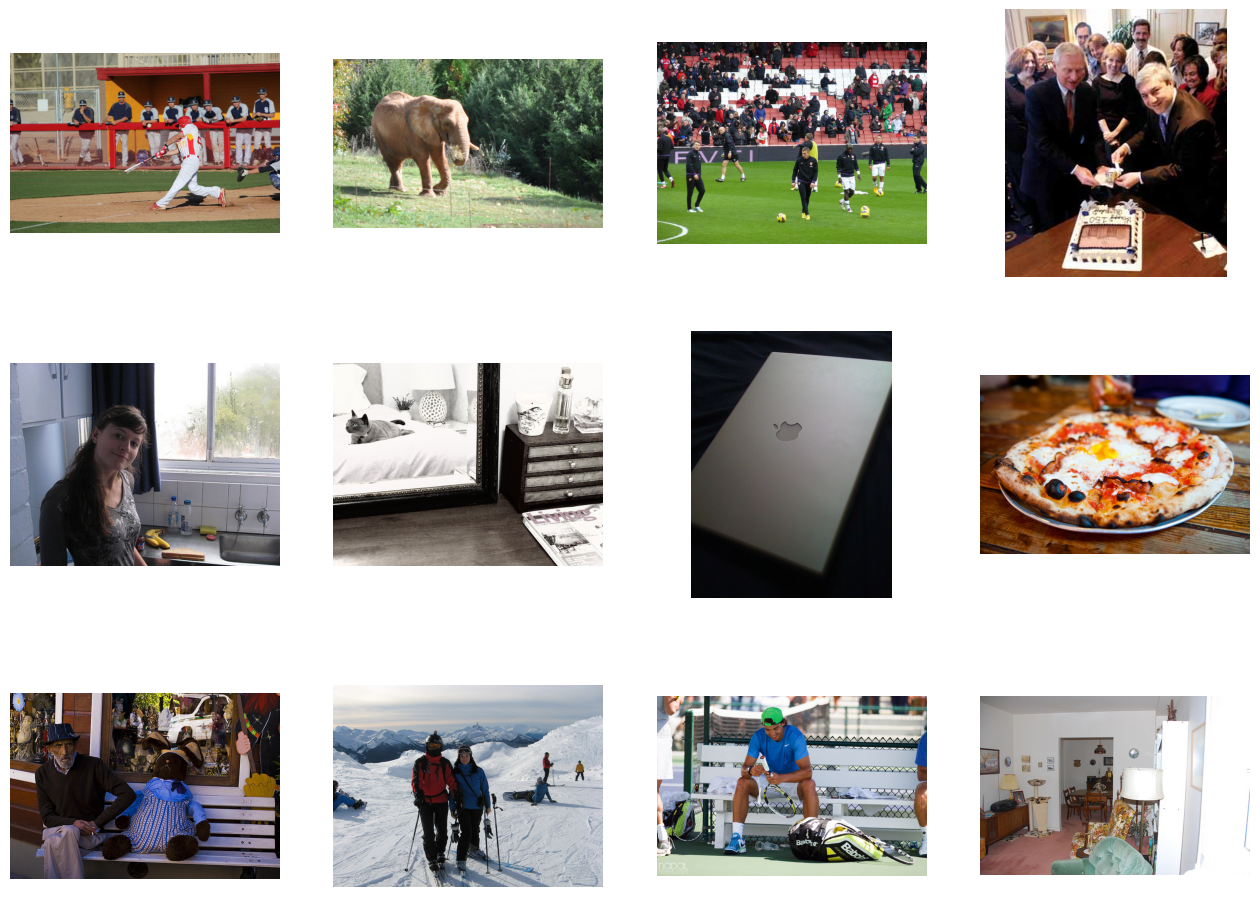

In [36]:
# 랜덤 파일 읽기, imgidss 확인!! -전체코코인지 일부인지
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    I = io.imread(img_path)
    plt.imshow(I)
    print( updated_dict[img_path][0])

plt.show()

In [37]:
print("Total images for training: ", len(imgIdss))

Total images for training:  10000


# Prepare Dataset 

#### Group all captions together having the same image and store them in dict.

In [38]:
# dataset = dict()
# imgcaptions = []

# for imgid in imgIdss:
#     img = coco.loadImgs(imgid)[0]
#     annIds = coco_caps.getAnnIds(imgIds=img['id']);
#     anns = coco_caps.loadAnns(annIds)
#     imgcaptions = []
#     for cap in anns:
        
#         # Remove punctuation
#         cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
#         # Replace - to blank
#         cap = cap.replace("-"," ")
        
#         # Split string into word list and Convert each word into lower case
#         cap = cap.split()
#         cap = [word.lower() for word in cap]
        
#         # join word list into sentence and <start> and <end> tag to each sentence which helps 
#         # LSTM encoder-decoder model while training.
        
#         cap = '<start> ' + " ".join(cap) + ' <end>'
#         imgcaptions.append(cap)
        
#     dataset[img['coco_url']] = imgcaptions 
    
# print("Length of Dataset: ",len(dataset))
# # print(dataset['http://images.cocodataset.org/train2017/000000047084.jpg'])
# #dataset

# print("type of Dataset: " ,type(dataset))



In [39]:
dataset =updated_dict

In [40]:
import itertools


# 임시 : sample은 개수

SAMPLE_NUM=10
testsample_dict= dict(itertools.islice(dataset.items(), SAMPLE_NUM))


# sample 쓴다고 가정
# dataset = testsample_dict

# Preprocess and tokenize the captions

In [41]:
from itertools import chain

def tokenize_mycaption(dataset, total_words=0):
  
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

  tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_words = len(tokenizer.word_index) + 1

  print("Vocabulary length: ", total_words)
  # print("Bicycle ID: ", tokenizer.word_index['bicycle'])
  # print("Airplane ID: ", tokenizer.word_index['airplane'])
  print(list(tokenizer.word_index.keys())[:10])
  return tokenizer, total_words

tokenizer, total_words= tokenize_mycaption(dataset)

Vocabulary length:  9774
['<oov>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man']


In [42]:

tokenizer, total_words

(<keras.preprocessing.text.Tokenizer at 0x7f6c2d3501f0>, 9774)

In [43]:

# import csv
# with open('/content/drive/MyDrive/3조/donut_token', 'r') as f:
#     csv_reader = csv.reader(f)
#     for line in csv_reader:
#      flatten_list =  line

# with open('/content/drive/MyDrive/3조/dataset', 'r') as f2:
#     csv_reader = csv.reader(f2)
#     for line in csv_reader:
#      dataset =  dataset


# # tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
# # tokenizer.fit_on_texts(flatten_list)
# # total_words = len(tokenizer.word_index) + 1

# tokenizer, total_words= tokenize_mycaption(dataset)
# print("sample:")
# sample_tokenizer , sample_total_words = tokenize_mycaption(testsample_dict)


In [44]:
print(total_words)
print(tokenizer.word_index)


9774
{'<oov>': 1, 'a': 2, 'on': 3, 'of': 4, 'the': 5, 'in': 6, 'with': 7, 'and': 8, 'is': 9, 'man': 10, 'to': 11, 'sitting': 12, 'an': 13, 'two': 14, 'standing': 15, 'at': 16, 'people': 17, 'are': 18, 'white': 19, 'next': 20, 'woman': 21, 'street': 22, 'holding': 23, 'table': 24, 'that': 25, 'person': 26, 'some': 27, 'it': 28, 'large': 29, 'down': 30, 'top': 31, 'field': 32, 'up': 33, 'group': 34, 'black': 35, 'tennis': 36, 'train': 37, 'his': 38, 'near': 39, 'riding': 40, 'front': 41, 'dog': 42, 'small': 43, 'cat': 44, 'plate': 45, 'by': 46, 'red': 47, 'young': 48, 'water': 49, 'room': 50, 'baseball': 51, 'walking': 52, 'playing': 53, 'bathroom': 54, 'while': 55, 'has': 56, 'grass': 57, 'blue': 58, 'sign': 59, 'pizza': 60, 'green': 61, 'there': 62, 'bus': 63, 'other': 64, 'parked': 65, 'food': 66, 'side': 67, 'snow': 68, 'bed': 69, 'building': 70, 'looking': 71, 'kitchen': 72, 'for': 73, 'ball': 74, 'beach': 75, 'three': 76, 'clock': 77, 'men': 78, 'couple': 79, 'skateboard': 80, 'boy

In [45]:
# 해당 만개 데이터에 대한 tokenizer 저장 (할필요가 있는지는 모르겠음)

import pickle

# Save the configuration and weights to a file
with open(f"my_tokenizer_{my_part}.pkl", "wb") as f:
    pickle.dump({"tokenizer": tokenizer}, f)




In [46]:
dataset_list = list(dataset)


rand = random.randrange(9999)

sample_link = dataset_list[rand]


sample_captions = dataset[sample_link]


sample_link, sample_captions

('/content/drive/MyDrive/destination_folder/train_folder01/000000046146.jpg',
 ['Homemade pizzas are cooling on the counter top. ',
  'A row of pizzas sit on tables underneath lamps. ',
  'A pizza -pie sits on a table in a restaurant',
  'Three yummy pizzas sitting under heat lamps on a counter',
  'Several pizzas sitting on trays under heating lamps.'])

In [47]:
# def process_an_image(img, imsize = (299,299)):

#     # io.imread -> image "img 파일은 http 주소 형태" #
 
#     for img in tqdm(dataset.keys()):
#         image = io.imread(img)
#         if image.ndim != 3:
#             image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
#         # Resize each image size 299 x 299
#         image = cv2.resize(image,imsize)
#         image = np.expand_dims(image, axis=0)
    
#         # Normalize image pixels
#         image = image/127.5
#         image = image - 1.0
#     return image

# test_img = process_an_image(dataset)

# test_img.shape

# Preprocess and caching the features extracted from InceptionV3

I will use InceptionV3 (which is pretrained on Imagenet) to classify each image. I will extract features from the last convolutional layer. This is also called a tranfer learning.

Since the Xception model was originally built for **imagenet**, we will do little changes for integrating with our model. Here, the Xception model takes **100 x 100 x 3** image size as input. We will remove the last classification layer and get the **2048 feature vector**.

In [48]:

# from tensorflow.keras.layers import GlobalAveragePooling1D

# def CNN_Encoder(): # Inception
#     inception_v3 = tf.keras.applications.InceptionV3(
#         include_top=False,
#         weights='imagenet'
#     )

#     output = inception_v3.output
#     print("output1\n", output,"\n------------------------------------------------------------")
#     # inception_v3.output , 즉    (None, 2048) 

#     output = tf.keras.layers.Reshape(
#         (-1, output.shape[-1]))(output)
#     # output after reshape

#     print("output2\n", output,"\n------------------------------------------------------------")

#     output = GlobalAveragePooling1D()(output)

#     cnn_model = tf.keras.models.Model(inception_v3.input, output)
#     return cnn_model, output



In [49]:
# model_incep = CNN_Encoder()[0]

# test_features = model_incep(test_img)


# test_features.shape



In [50]:
# model_incep.summary()


In [51]:
# Encoder 인 Xception 모델 호출, image_feature, imsize, error_imgs 선언, img_preprocess (이미지 사이즈 model 에 맞게 + resize, + 정규화 + feature 추출)


model = Xception(include_top=False, pooling='avg',  weights='imagenet')

# model.compile()

image_features = {}

imsize = (299,299)
# dataset.keys()
error_imgs = []
def img_preprocess(dataset=dataset,imsize=imsize, model=model):
    for img in tqdm(list(dataset.keys())):
        try:
            image = io.imread(img)
            if image.ndim != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Resize each image size 299 x 299
            image = cv2.resize(image, (imsize[1], imsize[0]))
            image = np.expand_dims(image, axis=0)

            # Normalize image pixels
            image = image / 127.5
            image = image - 1.0

            # Extract features from image
            feature = model.predict(image)
            image_features[img] = feature

        except:
            print(f"Failed to process image {img}")
            error_imgs.append[img]

83683744/83683744 [==============================] - 4s 0us/step


In [52]:
extract =False 

if extract == True:
  pass
# img_preprocess(dataset)
else:
  # /content/drive/MyDrive/3조/features_Xception/my_feature_10000_01.pkl
  # feature 파일 로드, (dict 형태)
  # 더 좋은 알고리즘이 있겠지만 ... 일단 이렇게

  with open("/content/drive/MyDrive/3조/features_Xception/my_feature_10000_01.pkl", "rb") as f:
    load_feature_file = pickle.load(f)


  load_features = list(load_feature_file.values())[0]

  print(type(load_features))
  keys = list(load_features.keys())
  values =list(load_features.values())


  load_feature_dict  = {}

  my_filepath_key =[sample_path+"/"+ key[-16:] for key in keys]

  for i in range(len(keys)):
      load_feature_dict[my_filepath_key[i]] = values[i]


  len(load_feature_dict)

  first_item_key = list(load_feature_dict.keys())[0]
  first_item_value = list(load_feature_dict.values())[0]

  # io.imread(first_item_key)


  # 다시 키를 내경로에 맞게 수정하는 과정 필요


  # plt.imshow(first_item_value)# feature = >이미지 decode 필요한데 불가능한듯. GAN 이나, 추가적인 decoder 모델 필요

  print(first_item_value.shape)

<class 'dict'>
(1, 2048)


000000000009.jpg
['/content/drive/MyDrive/destination_folder/train_folder01/000000000009.jpg', '/content/drive/MyDrive/destination_folder/train_folder01/000000000025.jpg', '/content/drive/MyDrive/destination_folder/train_folder01/000000000030.jpg', '/content/drive/MyDrive/destination_folder/train_folder01/000000000034.jpg', '/content/drive/MyDrive/destination_folder/train_folder01/000000000036.jpg']
73


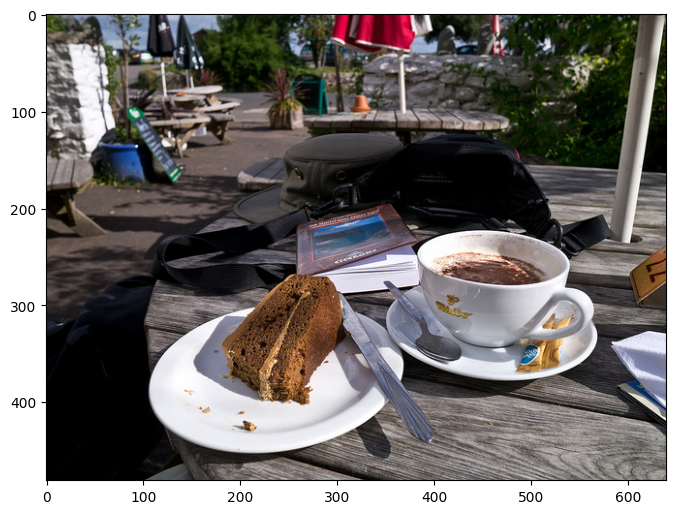

In [53]:
# 이미지 읽어보기 [0]

print(first_item_key[-16:])

print(my_filepath_key[:5])
print(len(my_filepath_key[0]))

# index [0:9999]
im = io.imread(my_filepath_key[23])

plt.imshow(im)
plt.show()


In [54]:
dataset[my_filepath_key[23]]

['A piece of cake and coffee are on an outdoor table.',
 'Slice of cake next to large filled cup on wooden table.',
 'A dessert and a cup of coffee sit next to a book and a purse.',
 'A slice of cake and mug sitting on a wooden table outside.',
 'a close up of a slice of cake on a plate']

In [55]:
# MobileNet Feature extraction 용

# IMAGE_SHAPE=(224, 224, 3)
# mobilenet = tf.keras.applications.MobileNetV3Small(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True)
# mobilenet.trainable=False


# img_preprocess(dataset, imsize =IMAGE_SHAPE, model = mobilenet)
# 뒤에 각모델마다  호출할때 모델 피팅 따로적용해야함


In [56]:
if load_feature_dict:
  image_features = load_feature_dict
  print("Image features length: ", len(image_features), len(load_feature_dict))
else :
  print("not valid")


Image features length:  10000 10000


In [57]:

# # Get the tokenizer's configuration and weights
# # image_features

# # 각자 Sampletrain 별로 저장하기 
# # ex) train

# with open(f"my_feature_{len(image_features)}_{my_part}.pkl", "wb") as f:
#     pickle.dump({"feature": image_features}, f)

In [58]:
# model = Xception(include_top=False, pooling='avg',  weights='imagenet')
# model.summary()

In [59]:
# mykeys = list(image_features.keys())
# my_key = mykeys[0]
# image_features[my_key].shape

In [60]:

# from keras.utils import plot_model

# model.summary()

# plot_model(model, to_file='model.png')


Here, I have found the max_length among the captions which will help to pad each caption with the same length.

In [61]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

49

# Make a Data Generator

We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

**The generator will yield the input and output sequence.**

##### For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

![Capture.PNG](attachment:abfdd0f4-ece1-4fe8-a9db-4060a31f10fd.PNG)

In [62]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            # print(([input_image, input_sequence], output_word))
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)


In [63]:

feature = image_features[sample_link][0]
dataset[sample_link]

a,b,c = create_sequences(tokenizer,max_length, dataset[sample_link],feature)
print(
a.shape,
b.shape,
c.shape
)

(40, 2048) (40, 49) (40, 9774)


In [65]:
for i in range(10):
  data_generator(dataset,image_features,tokenizer,max_length)

In [66]:
# On TPU Environment

import tensorflow as tf

# Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Updated TPUStrategy

else:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU/GPU

print("REPLICAS: ", strategy.num_replicas_in_sync)




REPLICAS:  1


In [66]:
# test TPU:


x= tf.ones((3, 3))
y = tf.ones((3, 3))

# Multiply matrices x and y using TPU
print("All devices: ", tf.config.list_logical_devices('TPU'))

with tf.device('/TPU:7'):
    z = tf.matmul(x, y)
    print(z)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
tf.Tensor(
[[3. 3. 3.]
 [3. 3. 3.]
 [3. 3. 3.]], shape=(3, 3), dtype=float32)


In [67]:
len(dataset)

type(dataset)

len(dataset.keys())

10000

In [103]:
# TPU 사용할때

def create_sequences_tpu(tokenizer, max_length, desc_list, feature, batch_size):
    X1, X2, y = list(), list(), list()

    count = 0
    while count < batch_size:
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=total_words)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

                count += 1
                if count >= batch_size:
                    break

            if count >= batch_size:
                break

    return np.array(X1), np.array(X2), np.array(y)


def data_generator_tpu(descriptions, features, tokenizer, max_length, batch_size):
    while True:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences_tpu(tokenizer, max_length, description_list, feature, batch_size)
            yield {'input_image': input_image, 'input_sequence': input_sequence}, {'output_word': output_word}


output_signature = (
    {
        'input_image': tf.TensorSpec(shape=(batch_size,2048), dtype=tf.float32),
        'input_sequence': tf.TensorSpec(shape=(batch_size,max_length), dtype=tf.float32)
    },
    {
        'output_word': tf.TensorSpec(shape=(batch_size,total_words), dtype=tf.float32)
    }
)

# Pass descriptions, features, tokenizer, and max_length as arguments

tpu_dataset=0
tpu_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_tpu(dataset, image_features, tokenizer, max_length),
    output_signature=output_signature
)
# print(tpu_dataset)
batch_size = 8 * strategy.num_replicas_in_sync
# tpu_dataset = tpu_dataset.batch(batch_size, drop_remainder=True)
prefetched_tpu =tpu_dataset.cache().prefetch(buffer_size=1)

print(prefetched_tpu)

<_PrefetchDataset element_spec=({'input_image': TensorSpec(shape=(64, 2048), dtype=tf.float32, name=None), 'input_sequence': TensorSpec(shape=(64, 49), dtype=tf.float32, name=None)}, {'output_word': TensorSpec(shape=(64, 9774), dtype=tf.float32, name=None)})>


In [104]:

tpu_caption_model.fit(prefetched_tpu,epochs=1, steps_per_epoch=steps_per_epoch)

InternalError: ignored

In [98]:
 keys = list(dataset.keys())
image_address = keys[3]
image_features[image_address]

array([[0.0000000e+00, 0.0000000e+00, 2.7756801e-02, ..., 0.0000000e+00,
        7.5076052e-05, 4.0233284e-01]], dtype=float32)

In [90]:
# generator_wrapper(dataset, image_features, tokenizer, max_length)
target_size = (299, 299,3)
AUTO = tf.data.experimental.AUTOTUNE






In [82]:

# print(prefetched_tpu)
# print(tpu_dataset.element_spec)

test = prefetched_tpu.batch(10)


for batch ,x in enumerate(test):
  pass

print("batch: ", batch)
# print("Data shape: ",x.shape)

InternalError: ignored

In [71]:

feature = image_features[sample_link][0]
dataset[sample_link]

a,b,c = create_sequences_tpu(tokenizer,max_length, dataset[sample_link],feature, batch_size)
print(
a.shape,
b.shape,
c.shape
)

(64, 2048) (64, 49) (64, 9774)


# Define CNN-LSTM Model

#### CNN (Convolution Neural Network)

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.


#### [Click here](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) to know more about CNN.

<br>

#### LSTM (Long short-term memory)


Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning


#### [Click here](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/) to know more about LSTM.


# Model Architechture 

### CNN-LSTM model:

- CNN is used for extracting features from the image. We will use the pre-trained model Xception.
- LSTM will use the information from CNN to help generate a description of the image.


### Model structure

![model.png](attachment:5e082228-cfa2-49fe-9526-fd31a45a9868.png)


* The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.<br> 
* An embedding layer will handle the text input,followed by the LSTM layer.
<br>
* Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [72]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,),name='input_image')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,),name='input_sequence')
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax', name = "output_word")(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [73]:
# train our model
import os

try:
  os.mkdir("models")
except:
  print("models folder already exists")

# testsample_dict
caption_model = define_model(total_words, max_length)


models folder already exists
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 49)]         0           []                               
                                                                                                  
 input_image (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 49, 256)      2502144     ['input_sequence[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_image[0][0]']            
                                                                 

In [74]:

with strategy.scope(): 
    tpu_caption_model = define_model(total_words, max_length)
    tpu_caption_model.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['categorical_crossentropy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 49)]         0           []                               
                                                                                                  
 input_image (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 49, 256)      2502144     ['input_sequence[0][0]']         
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_image[0][0]']            
                                                                                            

In [75]:
# # an_image = process_an_image("http://images.cocodataset.org/train2017/000000156510.jpg")


# a_key = list(dataset.keys())[0]
# img_location= a_key
# captions = dataset[a_key]
# print(img_location,"\n", captions)


# imgdata = process_an_image(a_key)

# print(imgdata.shape)

# plt.imshow(imgdata[0])


In [76]:
fit_num=0

BATCH_SIZE = 32


def train_our_model(dataset,batch =BATCH_SIZE, model =caption_model):
  global fit_num
  fit_num+=1

  print('Dataset: ', len(dataset))
  print('Descriptions: train=', len(dataset))
  print('Photos: train=', len(image_features))
  print('Vocabulary Size:', total_words)
  print('Description Length: ', max_length)

  epochs=1
  steps = len(dataset)

  # making a directory models to save our models

  
  for i in range(epochs):
      generator = data_generator(dataset, image_features, tokenizer, max_length)
      model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1, batch_size=BATCH_SIZE)
      model.save("models/model_" + str(i) +str(fit_num)+ ".h5")


<_PrefetchDataset element_spec=({'input_image': TensorSpec(shape=(64, 2048), dtype=tf.float32, name=None), 'input_sequence': TensorSpec(shape=(64, 49), dtype=tf.float32, name=None)}, {'output_word': TensorSpec(shape=(64, 9774), dtype=tf.float32, name=None)})>


In [79]:
print("All devices: ", tf.config.list_logical_devices('TPU'))


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [84]:
tpu_dataset = tpu_dataset.repeat()

steps_per_epoch = len(dataset) // batch_size
tpu_caption_model.fit(tpu_dataset, epochs=1, steps_per_epoch=steps_per_epoch)

OutOfRangeError: ignored

In [108]:

# # caption_model = define_model(total_words, max_length)
# caption_model2 = define_model(total_words, max_length)

# train_our_model(dataset, caption_model2)

In [119]:
print("Total samples:", len(dataset))
print("Batch size:", batch_size)
print("Steps per epoch:", steps_per_epoch)
# print("Total samples:", len(tpu_dataset))


Total samples: 10000
Batch size: 64
Steps per epoch: 156


In [218]:
print(tpu_dataset.cardinality().numpy())
tpu_dataset=tpu_dataset.repeat(2)
print(prefetched_tpu.cardinality().numpy())

dataset_length = tf.data.experimental.cardinality(tpu_dataset).numpy()
print("Number of elements in dataset:", dataset_length)



train_our_model_TPU(dataset)
prefetched_tpu = prefetched_tpu.repeat()

steps_per_epoch = len(dataset) // batch_size
history= tpu_caption_model.fit(prefetched_tpu, epochs=1, steps_per_epoch = steps_per_epoch)


-2
-1
Number of elements in dataset: -2


NameError: ignored

Dataset:  10000
Descriptions: train= 10000
Photos: train= 10000
Vocabulary Size: 9774
Description Length:  49


InternalError: ignored

In [111]:
tpu_caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 49)]         0           []                               
                                                                                                  
 input_image (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 49, 256)      2502144     ['input_sequence[0][0]']         
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_image[0][0]']            
                                                                                            

In [ ]:
train_our_model(dataset)

In [ ]:
train_our_model(testsample_dict)

In [ ]:
caption_model.summary()
caption_model.save("test_model.h5")

In [ ]:
loaded_model = tf.keras.saving.load_model("test_model.h5")


In [ ]:
# # model_incep_lstm


# # os.mkdir(models)


  
# train_our_model(testsample_dict, model2)
# model2.name
# model2.save("models/model2_f.h5")

In [ ]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break
print(img_paths)


In [ ]:

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


    


In [ ]:

xception_model = Xception(include_top=False, pooling="avg")




In [ ]:
photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(loaded_model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
# copy_model2 = load_model('./drive/MyDrive/3조/best_model.h5')
# copy_ssd = load_model('/content/drive/MyDrive/3조/ssd300.h5')

# copy_model2.summary()
# copy_ssd.summary()


In [ ]:
# plot_model(copy_ssd, to_file='model0.png')


In [ ]:
# plot_model(copy_model2, to_file='model1.png')


In [ ]:
# max_length =42
# generator = data_generator(dataset, image_features, tokenizer, max_length)


In [ ]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break



print(img_paths)



In [ ]:
len(img_paths)

In [ ]:


xception_model = Xception(include_top=False, pooling="avg")
for image in img_paths:
  photo = extract_features(image,xception_model )
  img = Image.open(image)
  description = generate_desc(model, tokenizer, photo, 49)
  print("\n\n")
  print(description)
  plt.imshow(img)

In [ ]:

# photo = extract_features(img_paths[1], copy_ssd)
# img = Image.open(img_paths[1])
# description = generate_desc(copy_model2, tokenizer, photo, 42)
# print("\n\n")
# print(description)
# plt.imshow(img)

In [ ]:
# import tensorflow as tf
# import numpy as np
# import json
# from tqdm import tqdm
# from sklearn.utils import shuffle 

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, BatchNormalization
# from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.layers import RepeatVector



# def build_cnn_lstm(vocab_size, max_length, embedding_dim=256, units=256):
#     # CNN Encoder (InceptionV3 pre-trained model)
#     inception = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
#     for layer in inception.layers:
#         layer.trainable = False

#     input_image = Input(shape=(299, 299, 3))
#     encoded_image = inception(input_image)
#     encoded_image = Dense(embedding_dim, activation='relu')(encoded_image)
#     encoded_image = Dropout(0.5)(encoded_image)
#     encoded_image = BatchNormalization()(encoded_image)
#     encoded_image = RepeatVector(max_length)(encoded_image)

#     # LSTM Decoder
#     input_caption = Input(shape=(max_length,))
#     embedding = Embedding(vocab_size, embedding_dim)(input_caption)
#     lstm_layer = LSTM(units, return_sequences=True)(embedding)
#     lstm_layer = Dropout(0.5)(lstm_layer)
#     lstm_layer = BatchNormalization()(lstm_layer)
    
#     # Merge CNN and LSTM layers
#     merged = Concatenate()([encoded_image, lstm_layer])

#     # Dense layers
#     decoder = LSTM(units, return_sequences=True)(merged)
#     decoder = Dropout(0.5)(decoder)
#     decoder = BatchNormalization()(decoder)
#     decoder = LSTM(units, return_sequences=False)(decoder)
#     decoder = Dropout(0.5)(decoder)
#     decoder = BatchNormalization()(decoder)
#     output_caption = Dense(vocab_size, activation='softmax')(decoder)

#     # Define the model
#     model = Model(inputs=[input_image, input_caption], outputs=output_caption)

#     return model
# vocab_size = total_words  # Size of your vocabulary (adjust according to your dataset)
# max_length = max_length  # Maximum length of a caption (adjust according to your dataset)
# embedding_dim = 256  # Dimension of the word embeddings
# units = 256  # Number of LSTM units

# model = build_cnn_lstm(vocab_size, max_length, embedding_dim, units)
# model.summary()

In [ ]:
def data_generator(images, captions, tokenizer, max_length, batch_size=10):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for img_path, img_captions in zip(images, captions):
            for caption in img_captions:
                n += 1

                # Preprocess image
                img = process_an_image(img_path)

                # Preprocess caption
                seq = tokenizer.texts_to_sequences([caption])[0]
                seq = pad_sequences([seq], maxlen=max_length, padding='post', truncating='post')[0]

                # Prepare input-output pairs
                for j in range(1, len(seq)):
                    in_seq, out_seq = seq[:j], seq[j]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)

                if n == batch_size:
                    print(f"X1 shape: {np.array(X1).shape}, X2 shape: {np.array(X2).shape}, y shape: {np.array(y).shape}")
                    yield ([np.array(X1, dtype=object), np.array(X2, dtype=object)], np.array(y, dtype=object))
                    X1, X2, y = [], [], []
                    n = 0




In [ ]:
# data_gen = data_generator(list(testsample_dict.keys()), list(testsample_dict.values()), tokenizer=sample_tokenizer, max_length=max_length)
# iter = 0
# for i in tqdm(data_gen, total=10):
#     iter += 1
#     if iter > 10:
#         break

In [ ]:
# data_gen = data_generator( list(testsample_dict.keys()),  list(testsample_dict.values()) ,tokenizer=sample_tokenizer,max_length=max_length)
# iter = 0
# for i in tqdm(data_gen):
#   iter +=1
#   if len(i >10:
#     break

In [ ]:
train_images = list(testsample_dict.keys())

train_captions = list(testsample_dict.values())

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Set parameters
epochs = 2
batch_size = 10
steps_per_epoch = len(train_images) // batch_size

# Train the model
for i in tqdm(range(epochs)):
    generator = data_generator(train_images, train_captions, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)
    model.save('model_' + str(i) + '.h5')